In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice

In [2]:
df = pd.read_csv('./data/clean_data.csv')

In [3]:
df.head()

,time,acc_x,acc_y,acc_z,speed,latitude,longitude,heading,road_speed_limit,road_type,diff_time,trip,anomalies_z_0.99,anomalies_z_0.95
0,2022-09-29 05:31:48.099,0.136,-0.025,1.032,28.5,43.202620,-2.894360,247.00000,40,SECONDARY_ROAD,0 days 00:00:11.100000,21,False,False
1,2022-09-29 05:31:48.199,0.114,-0.048,1.064,28.5,43.202618,-2.894369,247.34312,40,SECONDARY_ROAD,0 days 00:00:00.100000,21,False,False
2,2022-09-29 05:31:48.299,0.123,-0.059,1.031,28.5,43.202614,-2.894378,247.99690,40,SECONDARY_ROAD,0 days 00:00:00.100000,21,False,False
3,2022-09-29 05:31:48.399,0.123,-0.048,1.009,28.5,43.202614,-2.894388,248.79538,40,SECONDARY_ROAD,0 days 00:00:00.100000,21,False,False
4,2022-09-29 05:31:48.499,0.120,-0.087,0.997,28.5,43.202610,-2.894397,249.44058,40,SECONDARY_ROAD,0 days 00:00:00.100000,21,False,False


In [4]:
# def signals_extractor(acc:pd.DataFrame, anomalies_list:pd.DataFrame, trips_list:pd.DataFrame, n:int=10, signals_type:str='center'):
def signals_extractor(acc, anomalies_list, trips_list, n, signals_type):
    """
    This function extract anomalies signals

    acc : list of observations that we interested to extract anomalies signals from that 
    anomalies_list: show a point is anomaly or not (boolean list)
    trip_list: represent trips
    n: length of each signals of result
    signals_type: where anomally happend? 
            - To extract data that anomaly happened in the last value of the list we use "last" 
            - To extract data that anomaly happened in the center value of the list we use "center"
    """

    assert signals_type in ['last','center'] , "invalid signals_type. Please enter a valid signals_type from this list ['last','center']"

    df = pd.DataFrame({'acc':acc, 'is_anomaly':anomalies_list, 'trip':trips_list})

    trips = df['trip'].unique()

    if n%2 == 0:
        n = n-1
    
    result = pd.DataFrame()
    
    for trip in trips:
        dataframe = df.loc[df['trip']==trip].copy()
        dataframe.reset_index(inplace=True)
        
        index_anomalies = dataframe.loc[dataframe['is_anomaly']].index
        index_anomalies = index_anomalies[index_anomalies>n]
        
        Anomalies_df = np.zeros(shape=(len(index_anomalies), n))
        
        for i in range(len(index_anomalies)):
            if signals_type == "last": 
                signal = dataframe['acc'][index_anomalies[i]-(n-1):index_anomalies[i]+1]
                if len(signal) == n:
                    Anomalies_df[i] = signal
                    
            elif signals_type == "center":
                m = n
                m = int((m-1)/2)
                signal = dataframe['acc'][index_anomalies[i]-m : index_anomalies[i]+m+1]
                if len(signal) == n:
                    Anomalies_df[i] = signal
            else:
                print("invalid signals_type")
                break
        result =pd.concat([result,pd.DataFrame(Anomalies_df)], ignore_index=True)
    
    return result

In [5]:
anomalies_signals_df = signals_extractor(acc=df['acc_z'],
                                         anomalies_list=df['anomalies_z_0.95'],
                                         trips_list=df['trip'],
                                         n=31,
                                         signals_type='center')
anomalies_signals_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.013,1.063,1.096,1.031,1.071,1.022,1.010,1.006,0.988,1.009,...,1.143,1.086,1.009,0.895,0.873,0.891,0.976,1.037,1.129,1.090
1,1.063,1.096,1.031,1.071,1.022,1.010,1.006,0.988,1.009,1.004,...,1.086,1.009,0.895,0.873,0.891,0.976,1.037,1.129,1.090,0.990
2,1.010,1.006,0.988,1.009,1.004,0.964,0.916,0.929,1.130,1.298,...,0.976,1.037,1.129,1.090,0.990,0.923,0.899,1.007,1.115,1.131
3,1.008,0.959,0.978,0.983,1.004,1.038,1.100,1.090,1.059,1.065,...,1.031,1.127,1.233,1.083,0.995,0.924,0.952,0.977,1.064,1.086
4,0.959,0.978,0.983,1.004,1.038,1.100,1.090,1.059,1.065,1.015,...,1.127,1.233,1.083,0.995,0.924,0.952,0.977,1.064,1.086,1.065


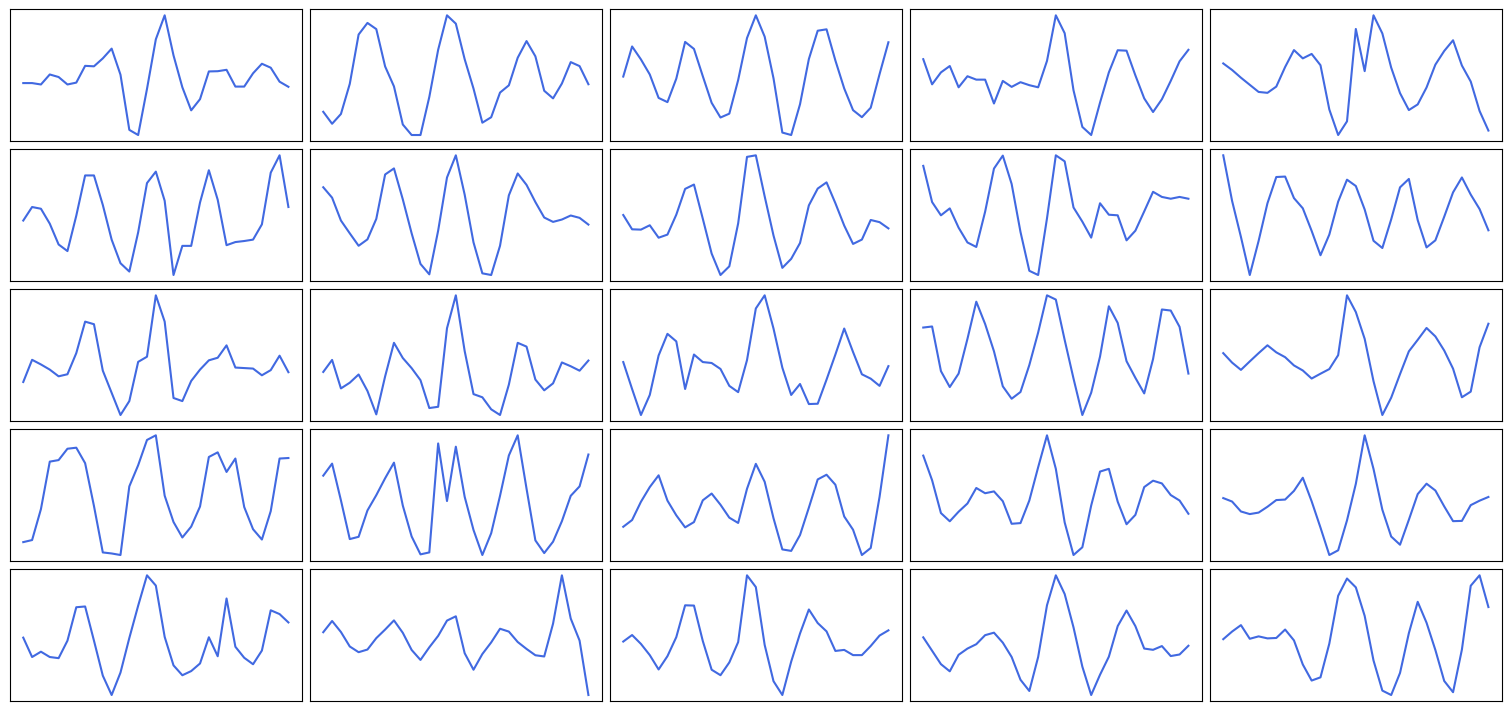

In [6]:
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained', nrows=5, ncols=5)

for row in ax:
    for col in row:
        col.plot(anomalies_signals_df.iloc[choice(range(len(anomalies_signals_df))),:], label='speed', color='royalblue')
        col.tick_params(labelbottom=False, labelleft=False,bottom=False, left=False)

plt.show()

In [7]:
# save the clean dataset to use in the future
anomalies_signals_df.to_csv('./data/anomalies_signals.csv', index=False)

<p>Now we are ready to create our clustering model</p>